# **寻找道路上的车道线** 
***

需要安装额外的库: conda install -c conda-forge moviepy

步骤包括:

    感兴趣区域选择
    
    灰度
    
    高斯平滑
    
    Canny边缘检测
    
    Hough Tranform线检测。

In [1]:
# 导入工具库
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
#读入图像
img = mpimg.imread('test_images/solidWhiteRight.jpg')

This is: <class 'numpy.ndarray'> with dimension: (540, 960, 3)


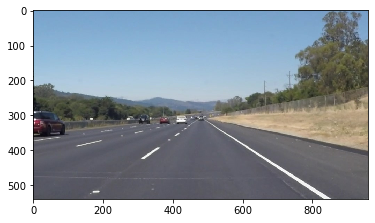

In [3]:
#输出图像特征,显示图像
print('This is:', type(img), 'with dimension:', img.shape)
plt.imshow(img)

In [4]:
import math
def grayscale(img):
    '''灰度变换'''
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def canny(img, low_threshold, high_threshold):
    '''边缘检测'''
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    '''高斯去噪'''
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def median_blur(img, kernel_size):
    '''中值去噪'''
    return cv2.median_blur(im5g, kernel_size)




def region_of_interest(img, vertices):
    '''图像蒙版'''
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (225, ) * channel_count  #python定义元组（tuple）时，如果只含一个元素，要在后面加逗号 
                                                    #(225,)*3=(225, 225, 225)
    else:
        ignore_mask_color = 225
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)# mask:需要填充的图， vertices:填充的区域，ignore_mask_color填充的颜色
    masked_img = cv2.bitwise_and(img, mask) #使用位运算中与操作，合并两张图片，一张图像放在另一个图像上面
    return masked_img
# bitwise_and是对二进制数据进行“与”操作，即对图像（灰度图像或彩色图像均可）每个像素值进行二进制“与”操作，1&1=1，1&0=0，0&1=0，0&0=0
# bitwise_or是对二进制数据进行“或”操作，即对图像（灰度图像或彩色图像均可）每个像素值进行二进制“或”操作，1|1=1，1|0=0，0|1=0，0|0=0
# bitwise_xor是对二进制数据进行“异或”操作，即对图像（灰度图像或彩色图像均可）每个像素值进行二进制“异或”操作，1^1=0,1^0=1,0^1=1,0^0=0
# bitwise_not是对二进制数据进行“非”操作，即对图像（灰度图像或彩色图像均可）每个像素值进行二进制“非”操作，~1=0，~0=1


def draw_lines(img, lines, color = [225, 0, 0], thickness = 2):
    '''画线段'''
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
#第一个参数 img：要划的线所在的图像;第二个参数 pt1：直线起点;第三个参数 pt2：直线终点
#第四个参数 color：直线的颜色;第五个参数 thickness=1：线条粗细

def get_y_intercept(lane_lines, slopes):
    '''根据输入的线段和斜率, 计算y方向的截距和平均斜率'''
    slopes = slopes[~np.isnan(slopes)]  
#  ~:按位取反运算符   
#np.isnan(x), 判断x值是否为空，为空返回True, 不为空返回False
    slopes = slopes[~np.isinf(slopes)]
    avg_slope = slopes.mean()
    lane_lines = lane_lines.reshape((lane_lines.shape[0]*2, lane_lines.shape[1]//2))   #?????
    x_mean, y_mean = np.mean(lane_lines, axis=0)
    return y_mean - (x_mean*avg_slope), avg_slope

def get_x_intercepts(y_1, y_2, slope, b):
    """根据斜率和截距, 计算对应y值的x"""
    if not (~np.isnan(slope) and ~np.isnan(b)):
        x_1 = x_2 = 0.0
    else:
        x_1 = (y_1 - b)/slope
        x_2 = (y_2 - b)/slope
    return x_1, x_2

prev_left_x1 = 0
prev_left_x2 = 0
prev_right_x1 = 0 
prev_right_x2 = 0 
prev_left_avg_m = 0
prev_right_avg_m = 0
pev_left_avg_m = -1
prev_right_avg_m = 1
prev_left_b = 0
prev_right_b = 0
prev_left_line = 0
prev_right_line = 0

def draw_lines_extrapolated(img, lines, color=[255, 0, 0], thickness=10):
    imgshape = img.shape
    lines = lines.reshape((lines.shape[0], lines.shape[2]))   #??????
    y_min = lines.reshape((lines.shape[0]*2, lines.shape[1]//2))[:,1].min()   #?????找道最远的那个点
    
    # slope= (    y2      -     y1   )/(    x2     -     x1    )  
    slopes = (lines[:,3] - lines[:,1])/(lines[:,2] - lines[:,0])  #找出每条线的斜率
    slopes = slopes[~np.isinf(slopes)]
    slopes = slopes[~np.isnan(slopes)]
    left_lines = lines[slopes < -0.5]   # 左边的行车道斜率为负，0.5是经验值
    right_lines= lines[slopes > 0.5]    # 右边的行车道斜率为正
    left_slopes = slopes[slopes < -0.5]
    right_slopes= slopes[slopes > 0.5]
    
    global prev_left_avg_m 
    global prev_right_avg_m 
    global prev_left_b
    global prev_right_b
    
    left_b, left_avg_m = get_y_intercept(left_lines, left_slopes) #得到左边的斜率和左边的截距
    right_b, right_avg_m = get_y_intercept(right_lines, right_slopes)  #得到右边的斜率和右边的截距

    keep_prev_left = False
    keep_prev_right = False
    
    if left_avg_m < -0.83 or left_avg_m > -0.36:
        left_avg_m = prev_left_avg_m
        left_b = prev_left_b
        keep_prev_left = True
    if right_avg_m > 0.83 or right_avg_m < 0.36:
        right_avg_m = prev_right_avg_m
        right_b = prev_right_b
        keep_prev_right = True
  
    prev_left_avg_m = left_avg_m 
    prev_right_avg_m = right_avg_m
    prev_left_b = left_b
    prev_right_b = right_b
    
    # 根据斜率和截距, 计算对应y值的x
    left_x1, left_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=left_avg_m, b=left_b)
    right_x1, right_x2 = get_x_intercepts(y_1=y_min, y_2=imgshape[0], slope=right_avg_m, b=right_b)
    
     ## 求累积平均值 ##
    global prev_left_x1
    global prev_left_x2
    global prev_right_x1 
    global prev_right_x2 

    if prev_left_x1 != 0 or prev_left_x2 != 0 or prev_right_x1 != 0 or prev_right_x2 !=0:
        alpha = 0.2
        left_x1_new = math.floor((alpha)*left_x1 + (1-alpha)*prev_left_x1)
        left_x2_new = math.floor((alpha)*left_x2 + (1-alpha)*prev_left_x2)
        right_x1_new = math.floor((alpha)*right_x1 + (1-alpha)*prev_right_x1)
        right_x2_new = math.floor((alpha)*right_x2 + (1-alpha)*prev_right_x2)
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new
    else:
        left_x1_new = left_x1
        left_x2_new = left_x2
        right_x1_new = right_x1
        right_x2_new = right_x2
        prev_left_x1 = left_x1_new
        prev_left_x2 = left_x2_new
        prev_right_x1 = right_x1_new
        prev_right_x2 = right_x2_new

    left_line = np.array([left_x1_new, y_min, left_x2_new, imgshape[0]], dtype=np.int32)
    right_line = np.array([right_x1_new, y_min, right_x2_new, imgshape[0]], dtype=np.int32)
    
    if keep_prev_left:
        left_line = prev_left_line
        left_x1_new = prev_left_x1
        left_x2_new = prev_left_x2
    if keep_prev_right:
        right_line = prev_right_line
        right_x1_new = prev_right_x1
        right_x2_new = prev_right_x2
        
    cv2.line(img, (int(left_x1_new), int(y_min)), (int(left_x2_new), imgshape[0]), color, thickness)
    cv2.line(img, (int(right_x1_new), int(y_min)), (int(right_x2_new), imgshape[0]), color, thickness)        
        
    ## 求累积平均值结束 ##
   
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=False):
    """
    霍夫变换
    `img` Canny边缘检测的输出.
    `rho` = Hough Grid中像素的距离
    `theta` = Hough grid中角度的距离
    `threshold` = 最小的voting数值,在霍夫空间中交叉点最小是多少
    `min_line_len` = 构成一条线的最小像素个数
    `max_line_gap` = 可以相连的线段之间的最大距离
    返回黑背景上面有白线的图.
    """ 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    print(lines[1:3])
    print(lines.shape)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if not extrapolate:
        draw_lines(line_img, lines)
    elif extrapolate:
        draw_lines_extrapolated(line_img, lines)
    
    return line_img
# 补充:霍夫变换
# void HoughLines(InputArray image, OutputArray lines, double rho, double theta, int threshold, double srn=0, double stn=0
#  )
# 参数:
# image:边缘检测的输出图像. 它应该是个灰度图 (但事实上是个二值化图)
# lines:储存着检测到的直线的参数对(r,theta(角度))的容器 
# rho:参数极径r以像素值为单位的分辨率.一般我们使用 1 像素.
# theta:参数极theta,以弧度为单位的分辨率.一般我们使用 1度 (即CV_PI/180)
# threshold: 要”检测” 一条直线所需最少的的曲线交点 
# minLinLength: 能组成一条直线的最少点的数量. 点数量不足的直线将被抛弃.线段的最小长度
# maxLineGap:线段上最近两点之间的阈值


def weighted_img(img, initial_img, a=0.8, b=1.):
    """
    python图片叠加与融合
    
    `img` hough_lines()的输出, 黑背景上面有白线的图.
    
    `initial_img` 原始图像.
    
    加权相加:
    
    initial_img * a + img * b 
    """
    return cv2.addWeighted(initial_img, a, img, b, 0)

# 补充：python图片叠加与融合，cv2.add与cv2.addWeighted的区别 
# 函数说明cv2.addWeighted(src1, alpha, src2, beta, gamma[, dst[, dtype]]) → dst ：加权叠加
# 参数说明
    #src1 – first input array.
    #alpha – weight of the first array elements.
    #src2 – second input array of the same size and channel number as src1.
    #beta – weight of the second array elements.
    #dst – output array that has the same size and number of channels as the input arrays.
    #gamma – scalar added to each sum.
    #dtype – optional depth of the output array; when both input arrays have the same depth, dtype can be set to -1, which will be equivalent to src1.depth().

In [5]:
import os
os.listdir("test_images/")

['challenge-area-1.png',
 'challenge-area.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

(540, 960, 3)


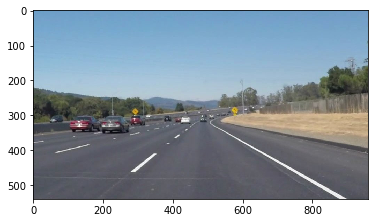

In [6]:
#读取并展示图片
img = mpimg.imread('test_images/solidWhiteCurve.jpg')
img_shape= img.shape
print(img_shape)
plt.imshow(img)

(540, 960)


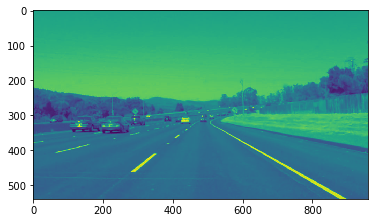

In [7]:
img_gray = grayscale(img) #变成黑白图
plt.imshow(img_gray)
print(img_gray.shape) #变成二维

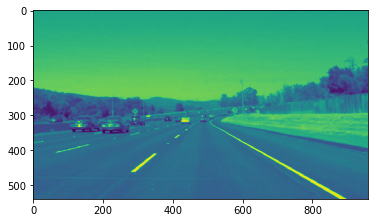

In [8]:
img_blur = gaussian_blur(img_gray, kernel_size=5)  # 降噪处理
plt.imshow(img_blur)

(540, 960)


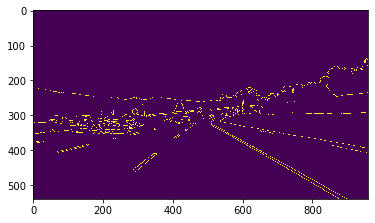

In [9]:
img_edge = canny(img_blur, low_threshold=50, high_threshold=150)  #边缘检测
plt.imshow(img_edge)
print(img_gray.shape) #变成二维

[[[  0 540]
  [425 315]
  [540 315]
  [960 540]]]
(1, 4, 2)
(540, 960)


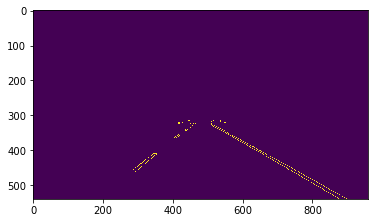

In [10]:
vertices = np.array([[(0,img_shape[0]),(425, 315), (540, 315), (img_shape[1],img_shape[0])]], \
                        dtype=np.int32)    #关注区域：左下角，左上角，右上角，右下角
print(vertices)
print(vertices.shape)
img_masked_edges = region_of_interest(img_edge, vertices)
plt.imshow(img_masked_edges)
print(img_gray.shape) #变成二维

In [11]:
# mask = np.zeros_like(img_edge)
# if len(img.shape) > 2:
#     channel_count = img.shape[2]
#     ignore_mask_color = (225, ) * channel_count  #python定义元组（tuple）时，如果只含一个元素，要在后面加逗号 ,  (225,)*3=(225, 225, 225)
# else:
#     ignore_mask_color = 225
# cv2.fillPoly(mask, vertices, ignore_mask_color)
# plt.imshow(mask)

[[[534 340 877 538]]

 [[496 316 897 539]]]
(8, 1, 4)


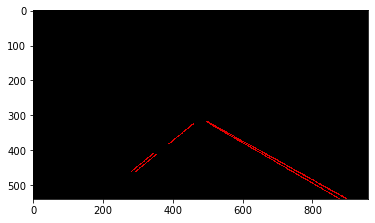

In [12]:
#霍夫变换
img_hough_lines = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20)
plt.imshow(img_hough_lines)




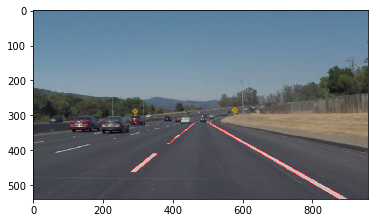

In [13]:
#图片叠加：两种方式
#方式一：
img_lanes = weighted_img(img=img_hough_lines, initial_img=img, a=0.8, b=1.)  #图片相加
#方式二：
# img_lanes = cv2.bitwise_or(img_hough_lines, img)
plt.imshow(img_lanes)


[[[534 340 877 538]]

 [[496 316 897 539]]]
(8, 1, 4)


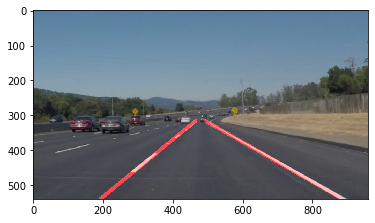

In [14]:
# Extrapolated lines
img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=60, max_line_gap=20, extrapolate=True)
img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=img, a =0.8, b=1.)
plt.imshow(img_lanes_extrapolated)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    #这个函数整合了前面的零散的代码
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    img_shape= image.shape
    img_gray = grayscale(image)
    
    
    img_blur = gaussian_blur(img_gray, kernel_size=5)
    img_edge = canny(img_gray, low_threshold=50, high_threshold=100)
    # For challenge video, use different parameters below
    #img_blur = gaussian_blur(img_gray, kernel_size=3) # for challenge video
    #img_edge = canny(img_blur, low_threshold=5, high_threshold=170)  # for challenge video 

    
    # to make this function moregeneral, I am using % of height and width of each video frame,
    # rather than using explicit vertices that I used while processing images above 
    vertices = np.array([[(img_shape[1]*0.20,img_shape[0]),(img_shape[1]*0.40, img_shape[0]*0.60), 
                          (img_shape[1]*0.55, img_shape[0]*0.60), (img_shape[1],img_shape[0])]], dtype=np.int32)
    # For challenge video, use different parameters below 
    #vertices = np.array([[(img_shape[1]*0.10,img_shape[0]),(img_shape[1]*0.40, img_shape[0]*0.60), 
    #                      (img_shape[1]*0.55, img_shape[0]*0.60), (img_shape[1],img_shape[0])]], dtype=np.int32)
    
    
    img_masked_edges = region_of_interest(img_edge, vertices)
    
    
    # Update the parameters in hough_lines to make it work on all videos
    img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=1, theta=np.pi/180, threshold=40,
                              min_line_len=10, max_line_gap=70, extrapolate=True)
    # For Challenge video, use different paremeters below 
    #img_hough_lines_extrapolated = hough_lines(img_masked_edges, rho=0.5, theta=np.pi/360, threshold=8,
    #                          min_line_len=5, max_line_gap=150, extrapolate=True)
    
    img_lanes_extrapolated = weighted_img(img=img_hough_lines_extrapolated, initial_img=image, a=0.8, b=1.)

    return img_lanes_extrapolated

### 测试视频上的检测效果

In [20]:
white_output = 'white.mp4'   #输出文件
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

[[[513 324 870 539]]

 [[511 325 671 425]]]
(10, 1, 4)
Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4

[[[513 324 870 539]]

 [[511 325 671 425]]]
(10, 1, 4)


t:   2%|█▏                                                                   | 4/221 [00:00<00:16, 13.22it/s, now=None]

[[[512 324 869 539]]

 [[519 327 756 470]]]
(10, 1, 4)
[[[513 324 867 537]]

 [[508 324 741 470]]]
(8, 1, 4)
[[[509 325 788 500]]

 [[508 324 700 444]]]
(7, 1, 4)
[[[508 324 749 475]]

 [[513 324 871 539]]]

t:   4%|██▍                                                                  | 8/221 [00:00<00:13, 15.30it/s, now=None]


(7, 1, 4)
[[[573 365 851 539]]

 [[509 324 742 470]]]
(7, 1, 4)
[[[509 324 853 539]]

 [[515 324 871 538]]]
(8, 1, 4)


t:   5%|███▋                                                                | 12/221 [00:00<00:13, 15.51it/s, now=None]

[[[509 324 853 539]]

 [[575 366 851 539]]]
(8, 1, 4)
[[[519 331 851 539]]

 [[599 382 850 539]]]
(9, 1, 4)
[[[591 379 847 539]]

 [[512 325 867 539]]]
(10, 1, 4)
[[[510 328 764 492]]

 [[503 324 693 447]]]
(13, 1, 4)


t:   6%|████▎                                                               | 14/221 [00:00<00:14, 14.10it/s, now=None]

[[[512 331 810 524]]

 [[245 483 456 324]]]
(9, 1, 4)
[[[509 325 762 483]]

 [[699 443 843 532]]]
(9, 1, 4)
[[[510 324 849 535]]

 [[625 403 834 539]]]
(7, 1, 4)


t:   7%|████▉                                                               | 16/221 [00:01<00:15, 13.50it/s, now=None]

[[[508 324 669 429]]

 [[649 417 836 539]]]
(8, 1, 4)
[[[521 328 772 497]]

 [[532 337 702 451]]]
(8, 1, 4)


t:  10%|██████▍                                                             | 21/221 [00:01<00:16, 12.33it/s, now=None]

[[[699 448 839 539]]

 [[512 324 679 433]]]
(9, 1, 4)
[[[512 325 705 451]]

 [[516 324 858 538]]]
(10, 1, 4)
[[[513 327 726 466]]

 [[612 392 759 488]]]
(10, 1, 4)
[[[507 324 731 470]]

 [[521 334 836 539]]]
(8, 1, 4)
[[[505 324 772 498]]

 [[639 412 834 539]]]

t:  11%|███████▍                                                            | 24/221 [00:01<00:13, 14.65it/s, now=None]


(10, 1, 4)
[[[520 334 835 539]]

 [[510 324 855 539]]]
(8, 1, 4)
[[[507 325 836 539]]

 [[659 425 834 539]]]
(8, 1, 4)
[[[654 421 835 539]]

 [[507 324 671 431]]]
(8, 1, 4)
[[[650 418 836 539]]

 [[508 324 645 413]]]
(10, 1, 4)
[[[527 337 743 478]]

 [[673 433 836 539]]]

t:  14%|█████████▏                                                          | 30/221 [00:01<00:10, 18.78it/s, now=None]


(8, 1, 4)
[[[507 324 837 539]]

 [[513 324 855 538]]]
(8, 1, 4)
[[[531 340 837 539]]

 [[523 331 856 539]]]
(8, 1, 4)
[[[528 338 837 539]]

 [[527 334 852 537]]]
(9, 1, 4)
[[[554 355 837 539]]

 [[508 324 697 447]]]
(7, 1, 4)
[[[614 394 837 539]]

 [[514 324 859 539]]]

t:  15%|██████████▍                                                         | 34/221 [00:02<00:08, 21.54it/s, now=None]


(8, 1, 4)
[[[543 347 838 539]]

 [[328 410 449 325]]]
(8, 1, 4)
[[[513 325 761 479]]

 [[650 409 859 539]]]
(10, 1, 4)
[[[578 371 837 539]]

 [[510 324 676 427]]]
(7, 1, 4)
[[[532 337 849 535]]

 [[696 439 857 539]]]
(7, 1, 4)
[[[561 361 835 539]]

 [[270 452 452 324]]]
(8, 1, 4)
[[[592 382 833 539]]

 [[754 476 856 539]]]
(10, 1, 4)


t:  19%|████████████▌                                                       | 41/221 [00:02<00:07, 23.55it/s, now=None]

[[[599 386 834 539]]

 [[513 325 855 539]]]
(10, 1, 4)
[[[511 325 855 539]]

 [[666 430 834 539]]]
(8, 1, 4)
[[[608 391 836 539]]

 [[696 449 834 539]]]
(11, 1, 4)
[[[512 325 703 453]]

 [[658 422 801 518]]]
(9, 1, 4)


t:  20%|█████████████▌                                                      | 44/221 [00:02<00:07, 22.93it/s, now=None]

[[[511 324 855 539]]

 [[518 329 727 469]]]
(9, 1, 4)
[[[512 324 853 537]]

 [[624 401 812 524]]]
(10, 1, 4)
[[[512 324 799 517]]

 [[525 332 856 539]]]
(9, 1, 4)
[[[542 344 832 539]]

 [[510 324 733 474]]]
(12, 1, 4)
[[[514 324 852 536]]

 [[511 324 746 482]]]

t:  21%|██████████████▍                                                     | 47/221 [00:02<00:07, 22.87it/s, now=None]


(12, 1, 4)
[[[529 335 828 536]]

 [[640 404 856 539]]]
(9, 1, 4)


t:  23%|███████████████▍                                                    | 50/221 [00:03<00:18,  9.40it/s, now=None]

[[[514 324 676 426]]

 [[655 414 854 539]]]
(9, 1, 4)
[[[531 337 831 539]]

 [[513 324 707 446]]]
(8, 1, 4)
[[[513 326 805 522]]

 [[513 324 832 539]]]
(7, 1, 4)
[[[516 328 796 516]]

 [[576 364 852 537]]]
(8, 1, 4)


t:  24%|████████████████                                                    | 52/221 [00:03<00:15, 10.92it/s, now=None]

[[[578 365 852 537]]

 [[513 326 765 495]]]
(9, 1, 4)


t:  24%|████████████████▌                                                   | 54/221 [00:04<00:31,  5.23it/s, now=None]

[[[514 324 700 441]]

 [[679 429 854 539]]]
(7, 1, 4)
[[[515 325 697 439]]

 [[522 330 844 532]]]
(9, 1, 4)
[[[523 333 751 486]]

 [[647 415 832 539]]]
(8, 1, 4)
[[[754 477 853 539]]

 [[609 392 835 539]]]
(11, 1, 4)


t:  27%|██████████████████▏                                                 | 59/221 [00:04<00:24,  6.62it/s, now=None]

[[[623 402 833 539]]

 [[505 324 631 406]]]
(10, 1, 4)
[[[525 337 713 463]]

 [[509 324 812 528]]]
(10, 1, 4)
[[[510 325 815 531]]

 [[625 398 850 539]]]
(10, 1, 4)
[[[504 324 539 346]]

 [[601 381 790 503]]]
(12, 1, 4)
[[[601 382 821 524]]

 [[519 332 826 539]]]
(10, 1, 4)


t:  29%|███████████████████▋                                                | 64/221 [00:05<00:21,  7.37it/s, now=None]

[[[558 355 761 486]]

 [[630 400 845 539]]]
(7, 1, 4)
[[[629 400 844 539]]

 [[562 358 739 472]]]
(7, 1, 4)
[[[504 324 823 539]]

 [[505 324 825 539]]]
(9, 1, 4)
[[[523 335 725 462]]

 [[712 454 843 539]]]
(8, 1, 4)


t:  31%|████████████████████▉                                               | 68/221 [00:05<00:14, 10.23it/s, now=None]

[[[673 429 843 539]]

 [[504 324 823 539]]]
(8, 1, 4)
[[[510 324 691 441]]

 [[511 324 720 459]]]
(7, 1, 4)
[[[511 324 707 451]]

 [[762 484 848 539]]]
(8, 1, 4)
[[[511 324 763 487]]

 [[510 324 700 447]]]
(8, 1, 4)


t:  33%|██████████████████████▏                                             | 72/221 [00:06<00:14, 10.32it/s, now=None]

[[[508 326 824 539]]

 [[600 382 812 519]]]
(10, 1, 4)
[[[610 388 844 539]]

 [[514 327 630 402]]]
(10, 1, 4)
[[[621 395 844 539]]

 [[512 325 660 421]]]
(7, 1, 4)


t:  33%|██████████████████████▊                                             | 74/221 [00:06<00:13, 11.13it/s, now=None]

[[[647 412 843 539]]

 [[510 324 712 455]]]
(6, 1, 4)
[[[512 326 683 437]]

 [[544 352 821 539]]]
(8, 1, 4)
[[[675 431 842 539]]

 [[515 328 712 456]]]
(7, 1, 4)


t:  35%|████████████████████████                                            | 78/221 [00:06<00:11, 12.08it/s, now=None]

[[[513 326 841 539]]

 [[509 325 718 460]]]
(7, 1, 4)
[[[552 357 821 539]]

 [[614 400 820 539]]]
(7, 1, 4)
[[[506 324 692 454]]

 [[507 324 803 516]]]

t:  36%|████████████████████████▌                                           | 80/221 [00:06<00:10, 13.57it/s, now=None]


(9, 1, 4)
[[[511 328 775 512]]

 [[507 324 838 539]]]
(7, 1, 4)
[[[511 328 790 523]]

 [[319 407 447 324]]]
(7, 1, 4)
[[[506 324 835 538]]

 [[514 330 810 537]]]
(7, 1, 4)


t:  38%|██████████████████████████▏                                         | 85/221 [00:07<00:09, 13.68it/s, now=None]

[[[506 324 813 539]]

 [[508 325 727 468]]]
(8, 1, 4)
[[[506 324 813 539]]

 [[508 325 750 483]]]
(8, 1, 4)
[[[507 324 691 444]]

 [[515 330 780 503]]]
(6, 1, 4)
[[[527 336 649 418]]

 [[512 325 708 457]]]
(8, 1, 4)
[[[516 331 775 500]]

 [[656 423 833 538]]]
(8, 1, 4)
[[[522 335 790 510]]

 [[506 324 693 446]]]

t:  40%|███████████████████████████                                         | 88/221 [00:07<00:08, 15.09it/s, now=None]


(8, 1, 4)
[[[512 325 749 485]]

 [[555 360 810 539]]]
(10, 1, 4)
[[[511 324 815 529]]

 [[543 351 811 539]]]
(9, 1, 4)


t:  43%|████████████████████████████▉                                       | 94/221 [00:07<00:12, 10.37it/s, now=None]

[[[510 325 732 474]]

 [[513 325 823 534]]]
(10, 1, 4)
[[[517 330 749 486]]

 [[512 325 828 538]]]
(11, 1, 4)
[[[508 324 755 490]]

 [[709 458 830 539]]]
(10, 1, 4)
[[[510 325 738 490]]

 [[650 426 786 524]]]
(9, 1, 4)
[[[623 408 810 539]]

 [[586 381 779 517]]]
(10, 1, 4)


t:  44%|█████████████████████████████▊                                      | 97/221 [00:08<00:10, 12.10it/s, now=None]

[[[619 404 811 539]]

 [[512 325 830 539]]]
(13, 1, 4)
[[[513 325 828 537]]

 [[522 327 593 378]]]
(12, 1, 4)
[[[512 324 737 487]]

 [[524 332 759 502]]]
(9, 1, 4)


t:  46%|██████████████████████████████▉                                    | 102/221 [00:08<00:08, 14.72it/s, now=None]

[[[515 325 831 538]]

 [[512 324 547 348]]]
(9, 1, 4)
[[[517 324 784 505]]

 [[514 324 832 538]]]
(7, 1, 4)
[[[526 331 833 538]]

 [[749 492 814 539]]]
(9, 1, 4)
[[[565 357 831 537]]

 [[517 324 689 440]]]
(9, 1, 4)
[[[520 329 718 472]]

 [[653 424 812 539]]]
(8, 1, 4)
[[[572 368 815 539]]

 [[612 397 814 539]]]
(9, 1, 4)


t:  48%|███████████████████████████████▊                                   | 105/221 [00:08<00:07, 16.40it/s, now=None]

[[[509 324 816 539]]

 [[613 398 814 539]]]
(11, 1, 4)
[[[514 324 798 515]]

 [[516 324 835 539]]]
(9, 1, 4)
[[[511 324 816 538]]

 [[516 324 795 512]]]
(9, 1, 4)
[[[511 324 818 539]]

 [[514 325 641 414]]]

t:  50%|█████████████████████████████████▎                                 | 110/221 [00:08<00:06, 16.70it/s, now=None]


(8, 1, 4)
[[[606 390 818 539]]

 [[534 334 837 538]]]
(9, 1, 4)
[[[511 324 819 539]]

 [[513 324 820 539]]]
(8, 1, 4)
[[[534 335 823 529]]

 [[530 336 687 446]]]
(8, 1, 4)
[[[511 324 818 539]]

 [[528 335 820 539]]]

t:  52%|██████████████████████████████████▌                                | 114/221 [00:08<00:05, 19.02it/s, now=None]


(7, 1, 4)
[[[544 342 769 493]]

 [[714 455 839 539]]]
(7, 1, 4)
[[[562 353 797 511]]

 [[552 347 747 478]]]
(11, 1, 4)
[[[594 374 800 512]]

 [[515 324 586 369]]]
(9, 1, 4)
[[[534 338 798 522]]

 [[616 387 811 518]]]
(8, 1, 4)
[[[519 325 754 478]]

 [[714 453 845 539]]]
(11, 1, 4)


t:  54%|████████████████████████████████████▍                              | 120/221 [00:09<00:05, 20.13it/s, now=None]

[[[516 324 754 490]]

 [[530 333 825 539]]]
(9, 1, 4)
[[[520 326 821 536]]

 [[305 428 415 349]]]
(10, 1, 4)
[[[548 344 848 538]]

 [[512 324 718 463]]]
(10, 1, 4)
[[[593 373 848 538]]

 [[515 324 692 438]]]
(8, 1, 4)
[[[659 425 828 539]]

 [[657 416 843 533]]]

t:  56%|█████████████████████████████████████▎                             | 123/221 [00:09<00:04, 22.14it/s, now=None]


(10, 1, 4)
[[[674 427 852 539]]

 [[526 333 720 455]]]
(9, 1, 4)
[[[540 342 851 537]]

 [[514 325 702 443]]]
(7, 1, 4)
[[[513 326 851 537]]

 [[513 324 725 457]]]
(8, 1, 4)
[[[514 324 833 539]]

 [[515 324 708 445]]]
(7, 1, 4)


t:  58%|███████████████████████████████████████                            | 129/221 [00:09<00:04, 22.49it/s, now=None]

[[[559 357 764 491]]

 [[510 324 627 400]]]
(9, 1, 4)
[[[509 324 839 539]]

 [[510 324 711 455]]]
(7, 1, 4)
[[[555 354 839 539]]

 [[510 324 751 481]]]
(9, 1, 4)
[[[549 350 840 539]]

 [[509 324 780 500]]]
(8, 1, 4)


t:  60%|████████████████████████████████████████                           | 132/221 [00:09<00:04, 21.55it/s, now=None]

[[[514 324 859 539]]

 [[510 324 613 391]]]
(11, 1, 4)
[[[513 324 771 485]]

 [[516 325 847 531]]]
(9, 1, 4)
[[[570 365 838 539]]

 [[508 324 840 539]]]
(8, 1, 4)
[[[513 324 824 518]]

 [[514 324 828 520]]]
(9, 1, 4)
[[[510 324 841 539]]

 [[584 373 840 539]]]
(8, 1, 4)


t:  62%|█████████████████████████████████████████▊                         | 138/221 [00:10<00:03, 22.53it/s, now=None]

[[[518 324 861 538]]

 [[512 324 843 539]]]
(7, 1, 4)
[[[591 375 843 539]]

 [[514 324 845 539]]]
(10, 1, 4)
[[[515 325 844 539]]

 [[555 347 715 447]]]
(7, 1, 4)
[[[519 324 824 514]]

 [[729 454 866 539]]]
(7, 1, 4)
[[[517 324 803 502]]

 [[740 462 864 539]]]
(6, 1, 4)
[[[518 325 862 539]]

 [[515 324 796 499]]]
(7, 1, 4)
[[[516 325 831 521]]

 [[510 324 841 539]]]

t:  64%|███████████████████████████████████████████                        | 142/221 [00:10<00:03, 21.08it/s, now=None]


(10, 1, 4)
[[[508 324 839 539]]

 [[513 324 816 513]]]
(9, 1, 4)
[[[508 324 839 539]]

 [[509 324 715 458]]]
(8, 1, 4)
[[[510 324 759 486]]

 [[509 324 840 539]]]

t:  67%|████████████████████████████████████████████▊                      | 148/221 [00:10<00:03, 23.71it/s, now=None]


(11, 1, 4)
[[[516 325 859 539]]

 [[537 337 859 538]]]
(11, 1, 4)
[[[518 325 846 529]]

 [[231 495 454 327]]]
(12, 1, 4)
[[[517 324 712 445]]

 [[537 335 865 539]]]
(9, 1, 4)
[[[519 324 698 435]]

 [[548 341 812 505]]]
(10, 1, 4)


t:  68%|█████████████████████████████████████████████▊                     | 151/221 [00:10<00:03, 19.92it/s, now=None]

[[[522 327 800 495]]

 [[631 400 801 507]]]
(10, 1, 4)
[[[518 324 811 514]]

 [[532 335 718 455]]]
(11, 1, 4)
[[[613 388 767 485]]

 [[520 326 872 538]]]
(10, 1, 4)
[[[516 324 840 534]]

 [[514 325 757 482]]]
(11, 1, 4)
[[[539 340 836 532]]

 [[516 324 675 420]]]

t:  70%|██████████████████████████████████████████████▋                    | 154/221 [00:10<00:03, 21.21it/s, now=None]


(10, 1, 4)
[[[572 355 839 521]]

 [[549 342 773 481]]]
(8, 1, 4)
[[[572 355 815 506]]

 [[250 481 459 324]]]
(7, 1, 4)
[[[658 407 866 536]]

 [[573 355 792 491]]]
(10, 1, 4)


t:  73%|████████████████████████████████████████████████▊                  | 161/221 [00:11<00:02, 21.18it/s, now=None]

[[[665 411 865 535]]

 [[241 488 459 324]]]
(9, 1, 4)
[[[522 325 845 534]]

 [[233 494 459 324]]]
(11, 1, 4)
[[[515 324 777 488]]

 [[745 469 857 539]]]
(8, 1, 4)
[[[551 346 860 539]]

 [[666 418 859 539]]]
(12, 1, 4)
[[[632 389 883 539]]

 [[518 324 862 539]]]
(8, 1, 4)
[[[520 326 858 537]]

 [[530 332 862 539]]]
(8, 1, 4)


t:  76%|██████████████████████████████████████████████████▋                | 167/221 [00:11<00:02, 20.42it/s, now=None]

[[[653 401 859 524]]

 [[521 325 864 539]]]
(11, 1, 4)
[[[512 324 753 469]]

 [[715 447 867 539]]]
(9, 1, 4)
[[[511 324 840 522]]

 [[344 416 462 324]]]
(7, 1, 4)
[[[509 324 868 539]]

 [[516 324 887 538]]]
(9, 1, 4)
[[[513 324 886 539]]

 [[509 324 825 514]]]

t:  77%|███████████████████████████████████████████████████▌               | 170/221 [00:11<00:02, 19.39it/s, now=None]


(8, 1, 4)
[[[513 324 886 539]]

 [[514 324 887 539]]]
(9, 1, 4)
[[[508 324 866 539]]

 [[560 356 864 539]]]
(8, 1, 4)
[[[508 324 866 539]]

 [[537 338 885 539]]]
(7, 1, 4)


t:  78%|████████████████████████████████████████████████████▍              | 173/221 [00:11<00:02, 17.01it/s, now=None]

[[[508 324 866 539]]

 [[193 539 459 324]]]
(8, 1, 4)
[[[573 364 864 539]]

 [[508 324 866 539]]]
(12, 1, 4)
[[[545 342 886 539]]

 [[628 397 864 539]]]

t:  80%|█████████████████████████████████████████████████████▎             | 176/221 [00:11<00:02, 19.48it/s, now=None]


(11, 1, 4)
[[[521 329 886 539]]

 [[513 325 881 537]]]
(8, 1, 4)
[[[519 328 879 535]]

 [[515 324 887 539]]]
(9, 1, 4)
[[[583 369 866 539]]

 [[511 324 836 511]]]
(9, 1, 4)
[[[594 376 865 539]]

 [[514 324 597 372]]]
(11, 1, 4)
[[[511 324 829 507]]

 [[603 381 866 539]]]
(11, 1, 4)


t:  82%|███████████████████████████████████████████████████████▏           | 182/221 [00:12<00:01, 20.20it/s, now=None]

[[[615 388 866 539]]

 [[567 354 887 539]]]
(8, 1, 4)
[[[621 390 869 539]]

 [[282 460 456 324]]]
(9, 1, 4)
[[[642 403 868 539]]

 [[518 324 891 539]]]
(10, 1, 4)
[[[517 324 890 539]]

 [[623 391 869 539]]]
(11, 1, 4)


t:  84%|████████████████████████████████████████████████████████           | 185/221 [00:12<00:01, 18.82it/s, now=None]

[[[624 391 870 539]]

 [[513 324 681 425]]]
(12, 1, 4)
[[[640 401 869 539]]

 [[514 324 690 430]]]
(13, 1, 4)
[[[519 324 807 503]]

 [[525 330 570 356]]]
(14, 1, 4)


t:  85%|████████████████████████████████████████████████████████▉          | 188/221 [00:12<00:02, 14.73it/s, now=None]

[[[645 402 861 536]]

 [[527 331 888 539]]]
(10, 1, 4)
[[[609 382 819 509]]

 [[520 328 680 424]]]
(9, 1, 4)
[[[514 324 873 539]]

 [[360 403 454 327]]]
(6, 1, 4)


t:  86%|█████████████████████████████████████████████████████████▌         | 190/221 [00:13<00:03,  8.79it/s, now=None]

[[[527 330 863 531]]

 [[520 324 878 539]]]
(8, 1, 4)
[[[550 337 780 469]]

 [[531 330 712 438]]]
(9, 1, 4)
[[[643 397 832 507]]

 [[522 324 808 483]]]
(9, 1, 4)


t:  87%|██████████████████████████████████████████████████████████▏        | 192/221 [00:13<00:03,  9.33it/s, now=None]

[[[514 324 831 507]]

 [[694 429 884 539]]]
(12, 1, 4)


t:  88%|██████████████████████████████████████████████████████████▊        | 194/221 [00:13<00:03,  7.71it/s, now=None]

[[[575 356 793 481]]

 [[527 330 853 525]]]
(10, 1, 4)
[[[515 325 867 536]]

 [[571 355 842 511]]]
(10, 1, 4)


t:  89%|███████████████████████████████████████████████████████████▋       | 197/221 [00:14<00:03,  6.42it/s, now=None]

[[[574 357 890 539]]

 [[197 539 458 328]]]
(10, 1, 4)
[[[509 324 868 539]]

 [[198 539 277 475]]]
(12, 1, 4)
[[[571 356 889 539]]

 [[510 324 867 538]]]
(8, 1, 4)


t:  90%|████████████████████████████████████████████████████████████▎      | 199/221 [00:14<00:02,  7.78it/s, now=None]

[[[556 347 890 539]]

 [[657 404 891 539]]]
(8, 1, 4)
[[[675 414 893 539]]

 [[512 324 869 538]]]
(11, 1, 4)
[[[626 387 890 539]]

 [[686 428 872 539]]]
(10, 1, 4)


t:  92%|█████████████████████████████████████████████████████████████▌     | 203/221 [00:14<00:01, 10.08it/s, now=None]

[[[551 344 717 439]]

 [[711 442 873 539]]]
(11, 1, 4)
[[[515 324 837 517]]

 [[597 369 777 472]]]
(11, 1, 4)
[[[667 410 893 536]]

 [[724 449 875 539]]]
(11, 1, 4)
[[[516 324 800 494]]

 [[692 423 901 539]]]
(10, 1, 4)


t:  94%|██████████████████████████████████████████████████████████████▊    | 207/221 [00:15<00:01, 10.27it/s, now=None]

[[[615 379 901 538]]

 [[512 324 598 372]]]
(10, 1, 4)
[[[751 455 902 539]]

 [[516 324 896 535]]]
(11, 1, 4)
[[[518 324 846 506]]

 [[517 324 903 538]]]
(13, 1, 4)
[[[523 329 762 467]]

 [[643 399 885 539]]]
(13, 1, 4)


t:  95%|███████████████████████████████████████████████████████████████▉   | 211/221 [00:15<00:01,  9.97it/s, now=None]

[[[643 399 885 539]]

 [[528 332 887 539]]]
(9, 1, 4)
[[[527 332 887 539]]

 [[599 368 908 539]]]
(9, 1, 4)
[[[526 329 899 535]]

 [[522 330 881 537]]]
(8, 1, 4)
[[[524 329 872 521]]

 [[509 324 595 373]]]
(10, 1, 4)


t:  97%|█████████████████████████████████████████████████████████████████▏ | 215/221 [00:16<00:00,  9.70it/s, now=None]

[[[527 331 903 539]]

 [[518 328 883 539]]]
(6, 1, 4)
[[[507 324 880 539]]

 [[513 324 902 539]]]
(6, 1, 4)
[[[509 325 880 539]]

 [[508 324 881 539]]]
(8, 1, 4)
[[[508 325 878 539]]

 [[511 324 899 539]]]
(9, 1, 4)


t:  99%|██████████████████████████████████████████████████████████████████ | 218/221 [00:16<00:00,  6.06it/s, now=None]

[[[511 324 899 539]]

 [[512 324 898 538]]]
(8, 1, 4)
[[[508 325 879 539]]

 [[219 522 434 342]]]
(11, 1, 4)


t: 100%|██████████████████████████████████████████████████████████████████▋| 220/221 [00:17<00:00,  6.01it/s, now=None]

[[[511 327 878 539]]

 [[512 324 898 538]]]
(9, 1, 4)
[[[515 329 878 539]]

 [[646 400 896 539]]]
(11, 1, 4)


[[[620 390 878 539]]

 [[513 324 894 536]]]
(10, 1, 4)
Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 20.5 s
